In [1]:
from pysparkmeos.partitions.grid.grid_partitioner import GridPartition
from pymeos import STBox, pymeos_initialize, pymeos_finalize, TGeogPointInst, TGeogPointSeq, TGeomPointInst
from datetime import timedelta
from functools import partial
from datetime import datetime, timezone
import contextily as cx
import distinctipy
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry as shp
from pymeos import *
from pymeos.plotters import (
    TemporalPointSequenceSetPlotter,
    TemporalPointSequencePlotter,
)

import matplotlib.pyplot as plt

from shapely import wkb, box
import pandas as pd

pymeos_initialize()

df = pd.read_csv("../../small_states_2022-06-27-00.csv")
df = df.dropna()
df = df.head(100)
df['dt'] = df['time'].apply(lambda t: datetime.fromtimestamp(t).strftime('%Y-%m-%d %H:%M:%S'))
df['pointStr'] = df.apply(lambda row: f"POINT({row['lon']} {row['lat']})@{row['dt']}+00", axis=1)
bounds = STBox(
        "STBOX XT(((-177.02969360351562,-46.421356201171875),(177.816650390625,70.29727935791016)),[2022-06-27 00:00:00+00, 2022-06-27 00:15:00+00])",
        geodetic=True)
tpoint = TGeogPointInst(
        "POINT(40.87294006347656 1.9229736328125)@2022-06-27 00:00:00+00",
        srid=0)
tpoint = tpoint.set_srid(0)
print(tpoint.__str__(), tpoint.x().start_value(), tpoint.y().start_value())

gp = GridPartition(3, bounds)

points = list(df['pointStr'])
tpoints = [TGeogPointInst(point, srid=0) for point in points]
first = df['pointStr'].at[0]
#print(TGeogPointInst(first))
df.head()

POINT(40.87294006347656 1.9229736328125)@2022-06-27 00:00:00+00 40.87294006347656 1.9229736328125


,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,spi,squawk,baroaltitude,geoaltitude,lastposupdate,lastcontact,dt,pointStr
0,1656288000,34718e,40.872940,1.922974,187.631064,245.543044,8.12800,IBE2601,False,False,False,417.0,5509.26,5814.06,1.656288e+09,1.656288e+09,2022-06-27 00:00:00,POINT(1.9229736328125 40.87294006347656)@2022-...
1,1656288000,ac6364,33.139048,-85.526266,237.239575,337.160319,0.00000,DAL749,False,False,False,5761.0,10363.20,11003.28,1.656288e+09,1.656288e+09,2022-06-27 00:00:00,POINT(-85.5262662926499 33.139048430879235)@20...
2,1656288000,406471,51.908569,1.838303,169.170746,286.065061,-0.65024,TOM891,False,False,False,3541.0,5478.78,5570.22,1.656288e+09,1.656288e+09,2022-06-27 00:00:00,POINT(1.8383026123046875 51.9085693359375)@202...
3,1656288000,a04417,33.757187,-83.458370,132.312157,228.625465,-0.32512,N116SK,False,False,False,1716.0,7955.28,8458.20,1.656288e+09,1.656288e+09,2022-06-27 00:00:00,POINT(-83.45837028659122 33.75718688964844)@20...
4,1656288000,c04aa1,42.869522,-79.307939,209.512017,355.493393,-7.80288,CGCGU,False,False,False,3622.0,5859.78,6088.38,1.656288e+09,1.656288e+09,2022-06-27 00:00:00,POINT(-79.3079393963481 42.86952209472656)@202...


/tmp/ipykernel_24413/2864703362.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Text(143.09722222222223, 0.5, 'Lat')

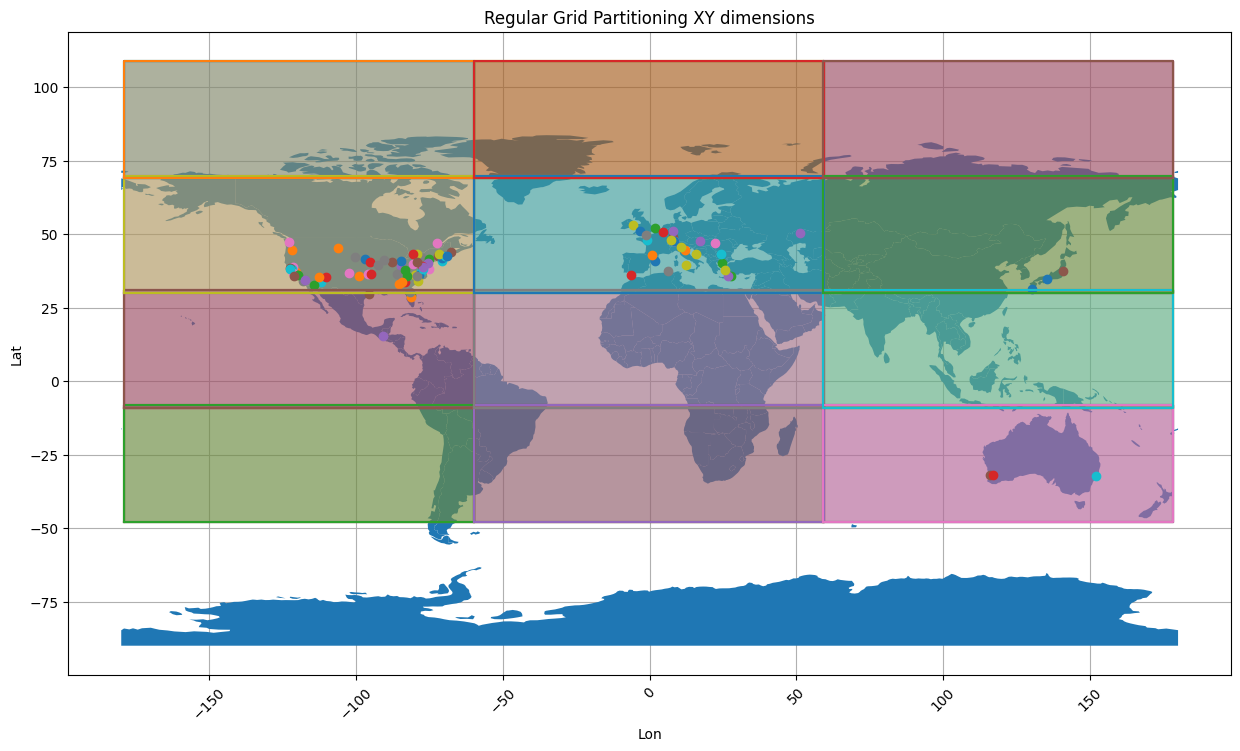

In [2]:
pymeos_initialize()

# Plot using GeoPandas' plot function, which is built on Matplotlib
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Create a bounding box
bounding_box = box(bounds.xmin(), bounds.ymin(), bounds.xmax(), bounds.ymax())

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.plot(ax=ax)
for tile in gp.grid:
    tile.plot_xy(axes=ax)

for point in tpoints:
    point = point.set_srid(0)
    interp = point.interpolation()
    tpointseq = point.to_sequence(interp).plot(axes=ax,label="tpoint")

#ax.set_xlim(bounds.xmin(), bounds.xmax())
#ax.set_ylim(bounds.ymin(), bounds.ymax())

plt.title("Regular Grid Partitioning XY dimensions")
plt.xlabel("Lon")
plt.ylabel("Lat")